## Importing required libraries

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

!pip install mlxtend
!pip install scikit-learn-extra

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report, ConfusionMatrixDisplay,precision_score,recall_score, f1_score,roc_auc_score,roc_curve, balanced_accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn_extra.cluster import KMedoids

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (C:\Users\Nikitha\anaconda3\Lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
#reading the dataset
data = pd.read_csv("data/stroke_data.csv")
data.head()

## Exploratory Data Analysis

In [ ]:
#shape of the data
data.shape

In [ ]:
data['stroke'].value_counts()

In [ ]:
data.info()

In [ ]:
#There are 3 rows that are missing a value in the "sex" column - because of the negligible count, we will just drop it
# Drop rows with NaN values in the 'sex' column
data = data.dropna(subset=["sex"])

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

In [ ]:
#Check if there are NA values.
data.isnull().sum().any()

In [ ]:
#Check if there are duplicate values.
data.duplicated().sum()

In [ ]:
# Now, there is no missing/duplicate data.
data.describe()

In [ ]:
# To analyze the data in a better way, we decided to convert the coding to the real values.

In [ ]:
data_vis = data.copy()
data_vis.sex[data_vis['sex'] == 0] = 'Female'
data_vis.sex[data_vis['sex'] == 1] = 'Male'

data_vis.hypertension[data_vis['hypertension'] == 0] = 'Not had hypertension'
data_vis.hypertension[data_vis['hypertension'] == 1] = 'Had hypertension'

data_vis.heart_disease[data_vis['heart_disease'] == 0] = 'Not had heart disease'
data_vis.heart_disease[data_vis['heart_disease'] == 1] = 'Had heart disease'

data_vis.ever_married[data_vis['ever_married'] == 0] = 'No'
data_vis.ever_married[data_vis['ever_married'] == 1] = 'Yes'

data_vis.work_type[data_vis['work_type'] == 0] = 'Never worked'
data_vis.work_type[data_vis['work_type'] == 1] = 'Children'
data_vis.work_type[data_vis['work_type'] == 2] = 'Govt job'
data_vis.work_type[data_vis['work_type'] == 3] = 'Self-employed'
data_vis.work_type[data_vis['work_type'] == 4] = 'Private'

data_vis.Residence_type[data_vis['Residence_type'] == 0] = 'Urban'
data_vis.Residence_type[data_vis['Residence_type'] == 1] = 'Rural'

data_vis.smoking_status[data_vis['smoking_status'] == 0] = 'Never smoked'
data_vis.smoking_status[data_vis['smoking_status'] == 1] = 'Smokes'

data_vis.stroke[data_vis['stroke'] == 0] = 'No'
data_vis.stroke[data_vis['stroke'] == 1] = 'Yes'

In [ ]:
unique_values = {}
for col in data_vis.columns:
    unique_values[col] = data_vis[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

In [ ]:
# The "work_type" column will need One Hot Encoder to process in nominal categorical data.
# "age", "avg_glucose_level" and "bmi" columns can be processed using Binning or Scaling.

In [ ]:
# Frequency of the value of the features in the dataset
feature_cols = [x for x in data_vis.columns if x not in 'stroke']
plt.figure(figsize=(25,35))
# loop for subplots
for i in range(len(feature_cols)):
    plt.subplot(8,5,i+1)
    plt.title(feature_cols[i])
    plt.xticks(rotation=90)
    plt.hist(data_vis[feature_cols[i]],color = "deepskyblue")
    
plt.tight_layout()

In [172]:
# There can't be a negative age, so lets drop these rows
data = data.drop(data[data.age < 0].index)
data_vis = data_vis.drop(data_vis[data_vis.age < 0].index)
len(data.index)

40852

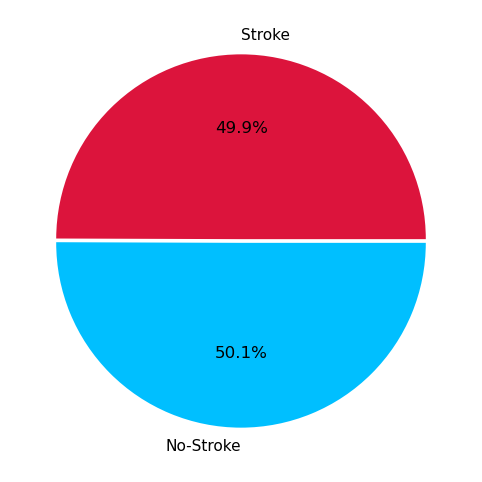

In [173]:
# We dropped 58 rows
# Traget values frequency
plt.figure(figsize=(8,6))
labels = ['Stroke', 'No-Stroke']
sizes = [data_vis['stroke'].value_counts()['Yes'],data_vis['stroke'].value_counts()['No']]
colors = ['crimson', 'deepskyblue']
explode = (0.01,0.01)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, autopct='%.1f%%', colors=colors, data = data_vis);

In [174]:
# The prediction column classes are balanced

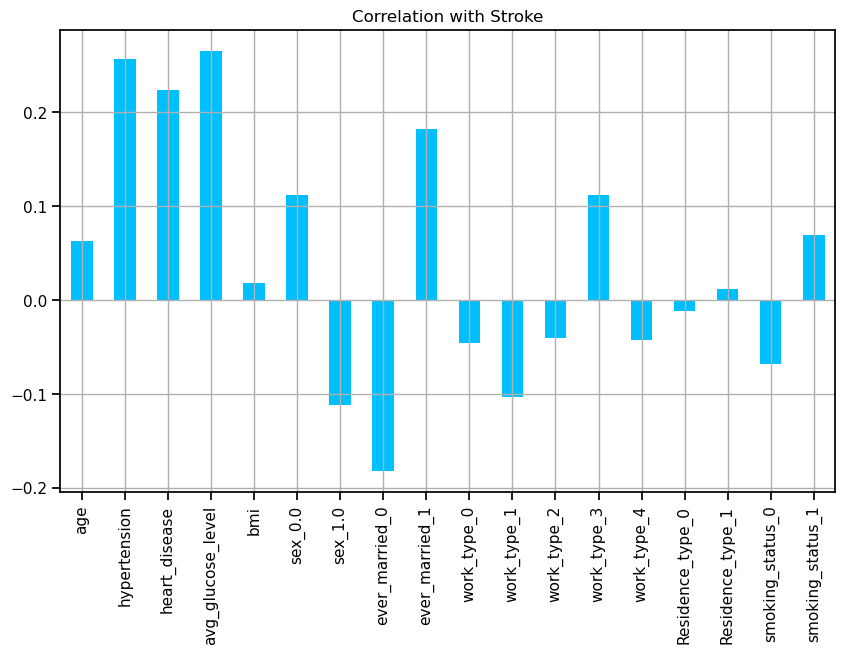

In [175]:
# Correlation between each feature and stroke
data.drop('stroke', axis=1).corrwith(data.stroke).plot(kind='bar', grid=True, figsize=(10, 6), title="Correlation with Stroke",color="deepskyblue");

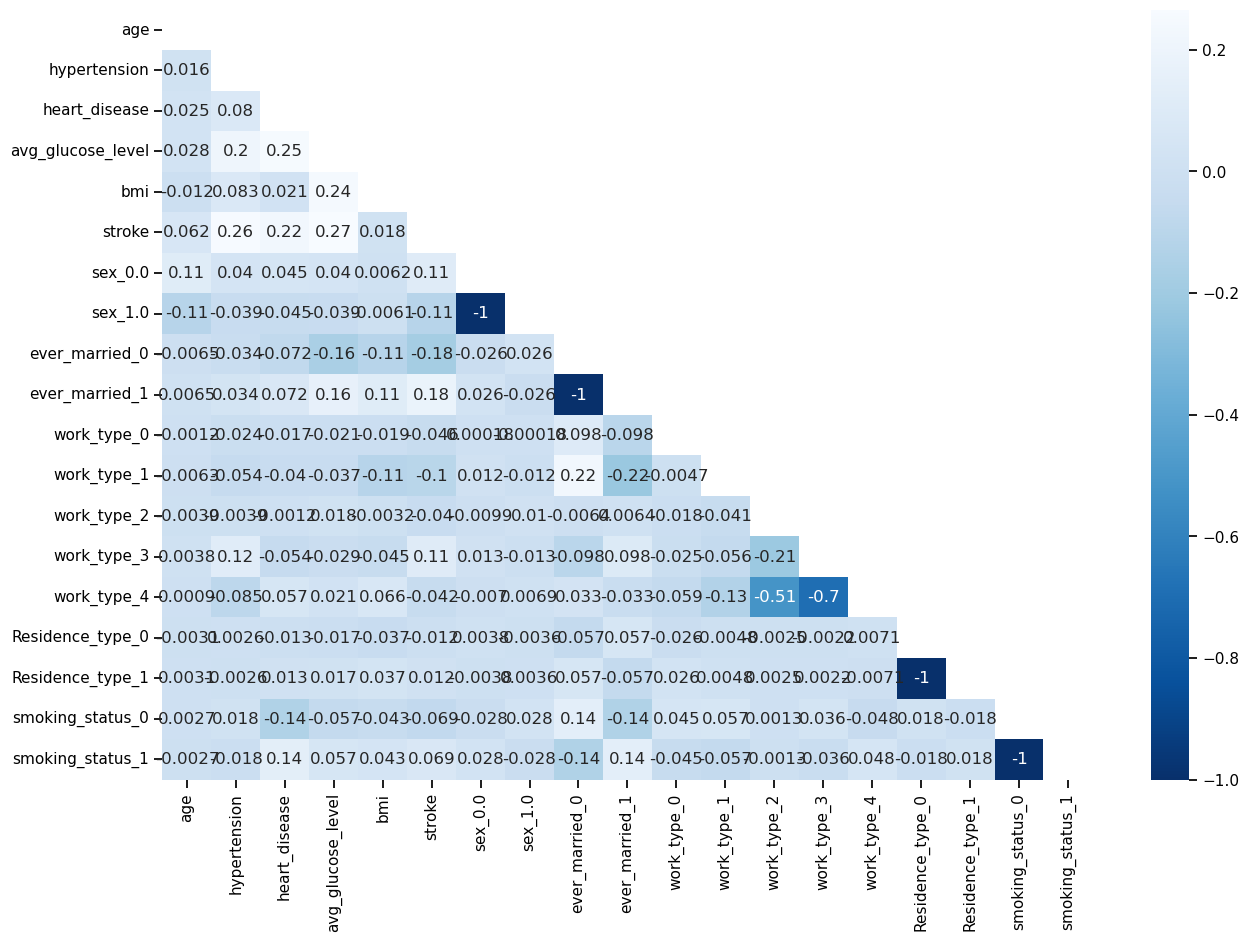

In [176]:
# The features "bmi", "Residence_type", "work_type" are least correlated with Storke. All other features have a significant correlation with Stroke.

# Correlation heatmap
plt.figure(figsize=(15,10))
mask=np.triu(data.corr())
sns.heatmap(data.corr(),mask=mask,annot=True,cmap='Blues_r')
plt.show()

TypeError: countplot() got multiple values for argument 'data'

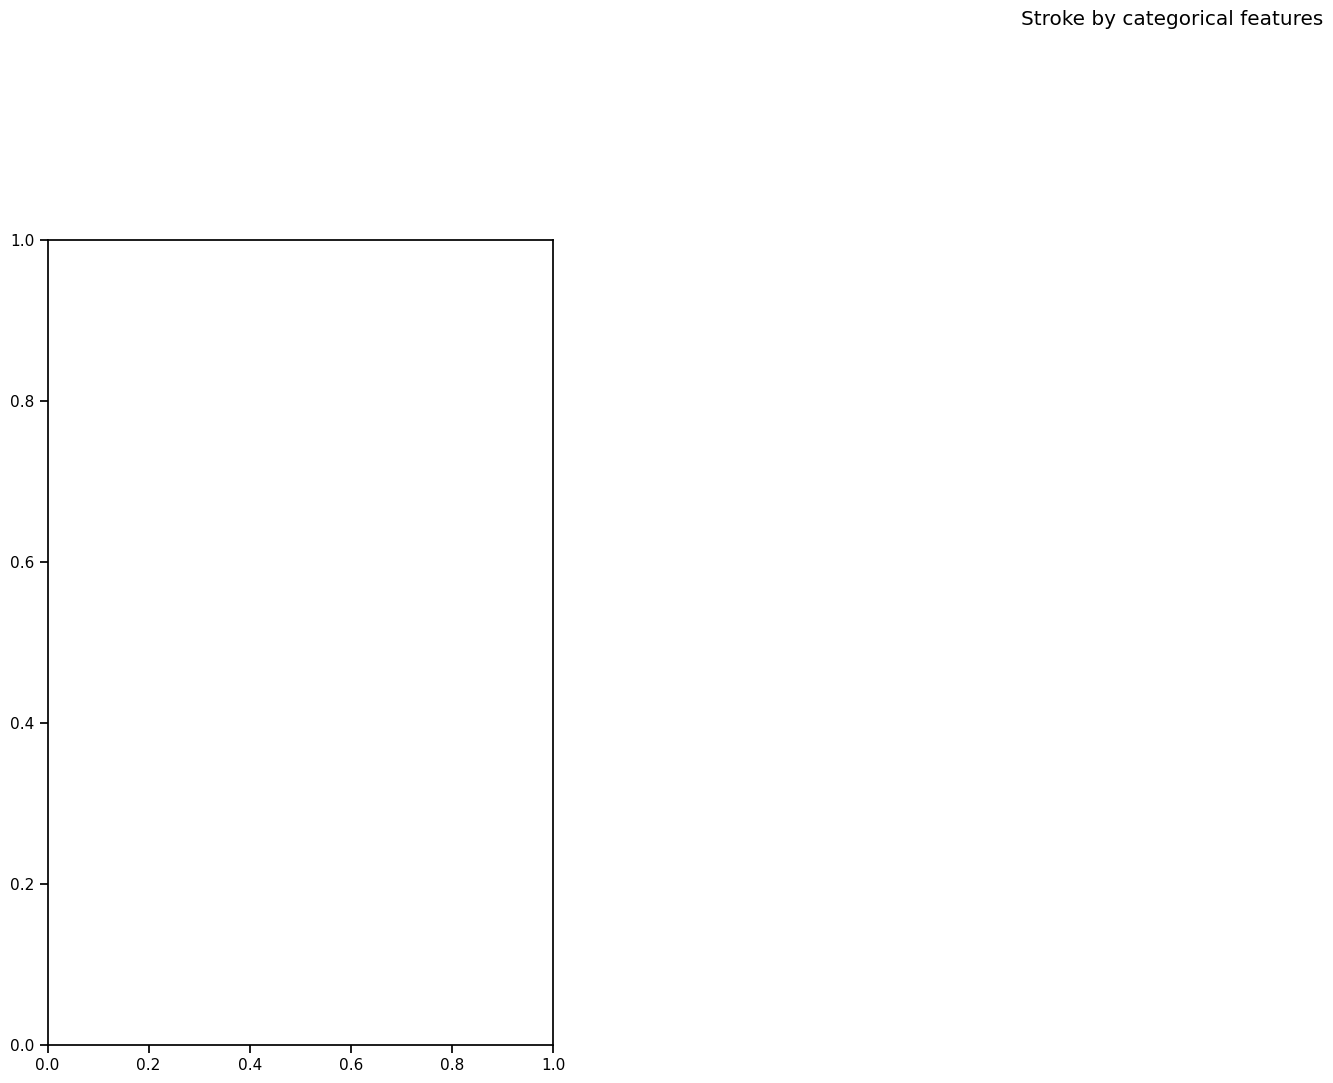

In [177]:
# There is no correlation higher than +- 0.3 for a pair of features. Therefore, we cannot drop features at this time.

# Stroke frequency by categorical features
features = [x for x in data_vis.columns if x not in ['stroke','bmi','age','avg_glucose_level']]
plt.figure(figsize = (30,23))
plt.suptitle('Stroke by categorical features')
#subplots
for i in enumerate(features):
    plt.subplot(2,4, i[0]+1)
    x = sns.countplot(i[1] ,hue='stroke', data=data_vis, palette = ['deepskyblue','crimson'])
    for z in x.patches:
      x.annotate('{:.1f}'.format((z.get_height()/data_vis.shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

In [178]:
# Sex has no effect on stroke.

# Smoking, hypertension and heart disease increase the risk of stroke.

# People whose type of work is "self employee" have a higher risk of stroke than other types of work.
# There is no clear connection between residence type and stroke, but there is a slight tendency to stroke in a rural residence type.


In [179]:
# Stroke frequency by numerical features

# scale the data before pairplot
data_pairplot = data.copy()
float_columns = [x for x in data.columns if x in ['bmi','age','avg_glucose_level']]

sc = StandardScaler()
data_pairplot[float_columns] = sc.fit_transform(data_pairplot[float_columns])
data_pairplot.head(4)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,sex_0.0,sex_1.0,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,Residence_type_0,Residence_type_1,smoking_status_0,smoking_status_1
0,0.538279,0,1,1.852569,0.906241,1,False,True,False,True,False,False,False,False,True,False,True,False,True
1,-0.436529,0,1,-0.280557,0.306405,1,False,True,False,True,False,False,False,False,True,True,False,True,False
2,0.445440,0,0,0.854203,0.584378,1,True,False,False,True,False,False,False,False,True,False,True,False,True
3,-0.482949,1,0,0.904417,-0.937158,1,False,True,False,True,False,False,False,True,False,True,False,True,False


C:\Users\Nikitha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


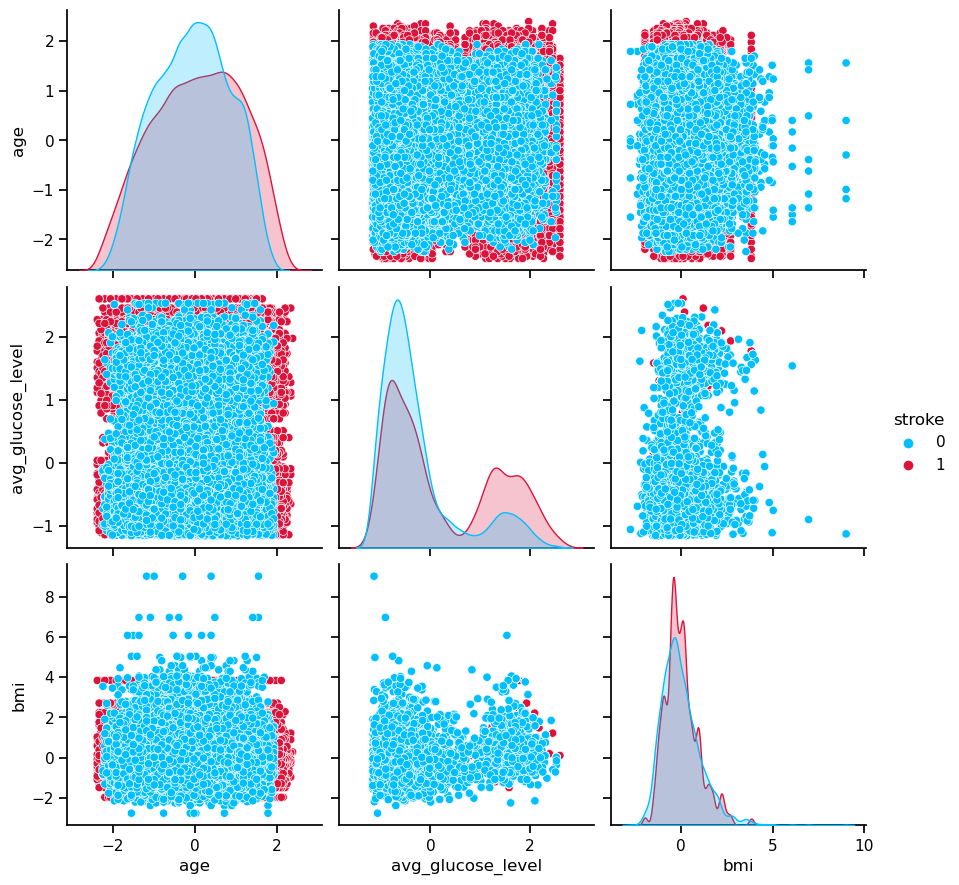

In [180]:
float_columns = [x for x in data_pairplot.columns if x in ['bmi','age','avg_glucose_level']]
sns.set_context('notebook')
sns.pairplot(data_pairplot[float_columns + ['stroke']], 
             hue='stroke', 
             hue_order=[0,1],
             height=3,
             palette={0:'deepskyblue',1:'crimson'});

C:\Users\Nikitha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x500 with 0 Axes>

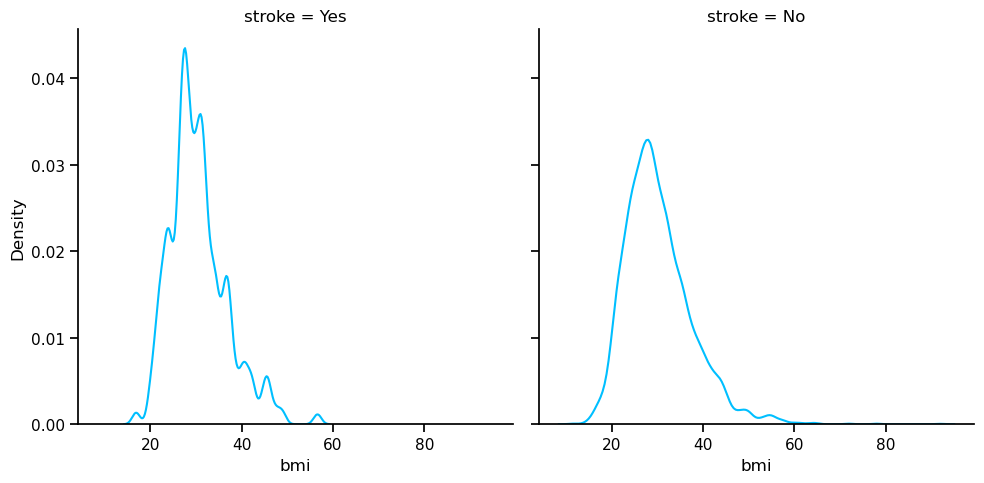

In [181]:
# Combining of float features does not seem to explain stroke.

# Numeric features distributions
# Bmi
plt.figure(figsize=(12,5))
sns.displot(x='bmi', col='stroke' , data = data_vis, kind="kde" ,color = 'deepskyblue');

C:\Users\Nikitha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x2000 with 0 Axes>

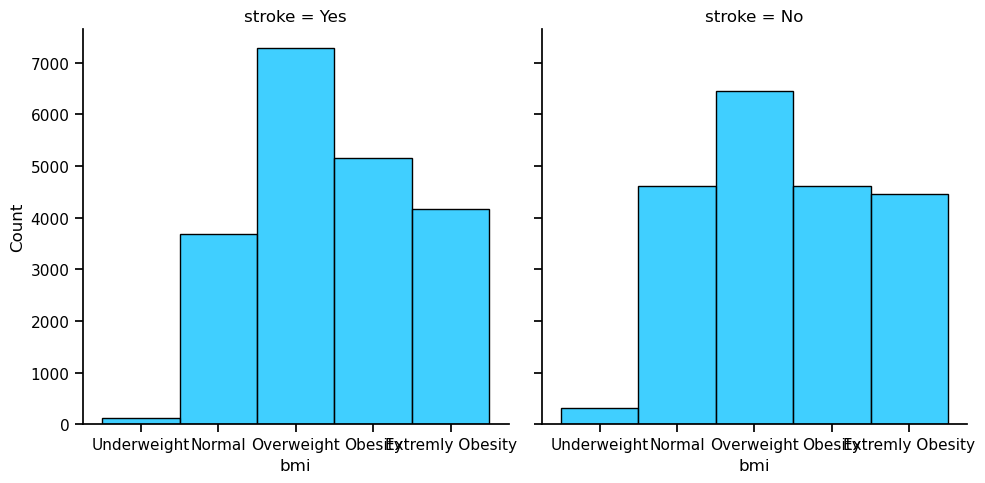

In [182]:
# Binning the data to see the distribution clearly
bmi = pd.cut( data_vis['bmi'],bins=[0,18.5,25,30,35,max(data_vis['bmi'])],labels=['Underweight','Normal','Overweight','Obesity','Extremly Obesity'])
plt.figure(figsize=(12,20))
sns.displot(data=data_vis,col='stroke',x=bmi,color='deepskyblue');

C:\Users\Nikitha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x500 with 0 Axes>

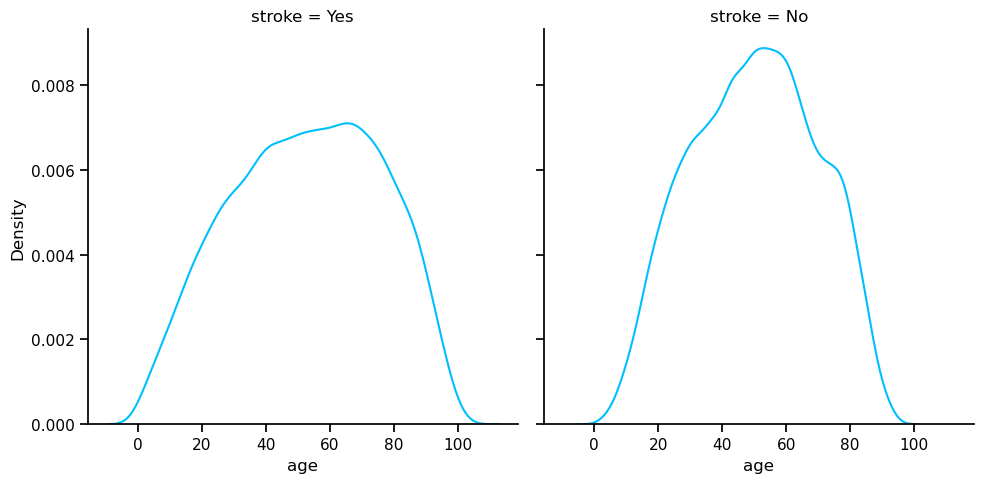

In [183]:
# The bmi's distribution of target column values are similar.

# Age
plt.figure(figsize=(12,5))
sns.displot(x='age', col='stroke' , data = data_vis, kind="kde" ,color = 'deepskyblue');

C:\Users\Nikitha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x500 with 0 Axes>

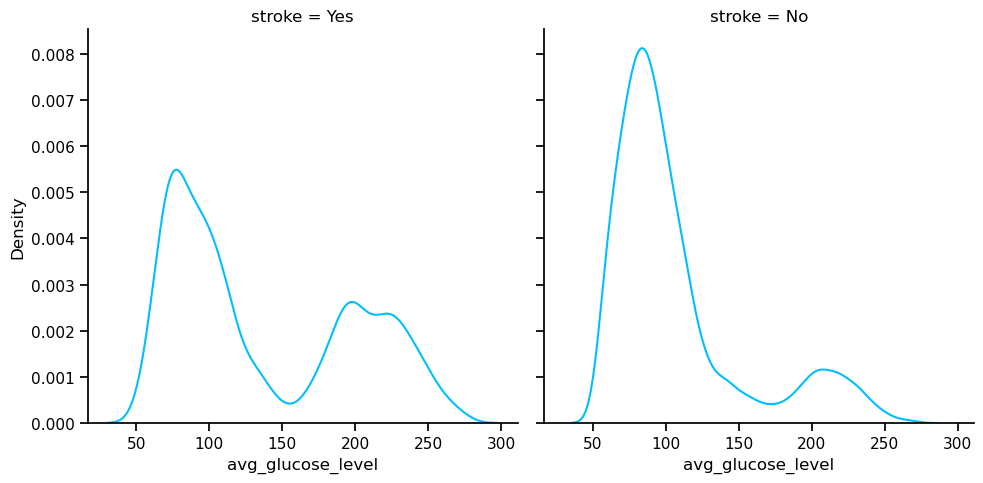

In [184]:
# The age's distribution of target column values are similar.

# avg_glucose_level
plt.figure(figsize=(12,5))
sns.displot(x='avg_glucose_level', col='stroke' , data = data_vis, kind="kde" ,color = 'deepskyblue');

C:\Users\Nikitha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

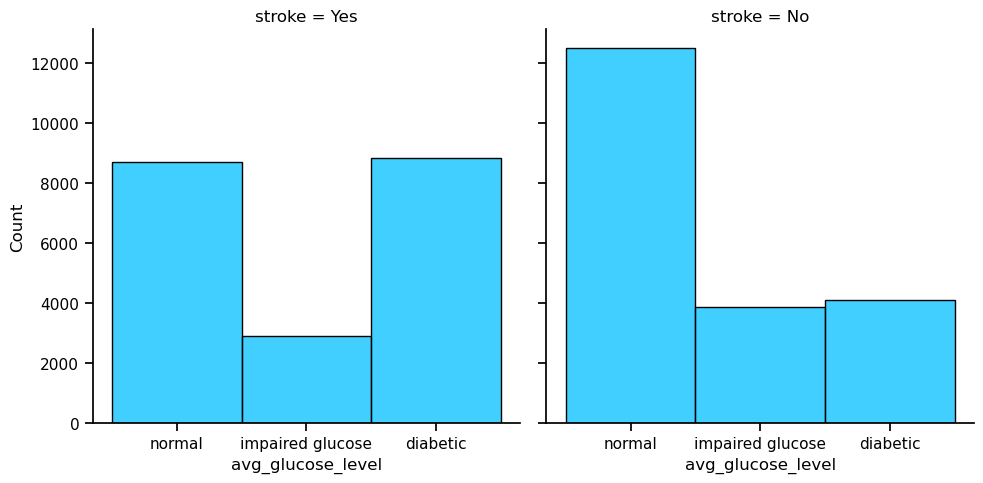

In [185]:
#Binning the data to see the distribution clearly

avg_glucose_level = pd.cut( data_vis['avg_glucose_level'],bins=[0,100,125,max(data_vis['avg_glucose_level'])],labels=['normal','impaired glucose','diabetic'])
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='stroke',x=avg_glucose_level,color='deepskyblue');

In [186]:
# The distribution of the average glucose level of the target column values is different. This feature is an explanatory feature; People with high blood glucose are more likely to have a stroke than those with normal values.

## Data preperation

In [208]:
# Drop values with low frequency
# Let's look at the "work_type" feature graph:
plt.figure(figsize=(8,6))
x = sns.countplot("work_type" ,hue='stroke', data=data_vis, palette = ['deepskyblue','crimson'])
for z in x.patches:
    x.annotate('{:.1f}'.format((z.get_height()/data_vis.shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

TypeError: countplot() got multiple values for argument 'data'

<Figure size 800x600 with 0 Axes>

In [ ]:
# Only 1.3 percent of the data are divided into the values "children", "never worked". In addition, neither of these two values had a stroke. This data can cause biases, so I will drop these records.

data.drop(data[data.work_type <= 1].index, inplace=True)
plt.figure(figsize=(8,6))
x = sns.countplot("work_type" ,hue='stroke', data=data, palette = ['deepskyblue','crimson'])
for z in x.patches:
    x.annotate('{:.1f}'.format((z.get_height()/data.shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

In [ ]:
# The "work_type" feature is of the Nominal Variable type. Therefore One Hot Encoder must be performed.

data.work_type[data['work_type'] == 2] = 'Govt job'
data.work_type[data['work_type'] == 3] = 'Self-employed'
data.work_type[data['work_type'] == 4] = 'Private'
one_hot_encode_cols = ['work_type']  # filtering by string categoricals
# Encode these columns as categoricals so one hot encoding works on split data 
for col in one_hot_encode_cols:
    data[col] = pd.Categorical(data[col])
# Do the one hot encoding
data = pd.get_dummies(data, columns=one_hot_encode_cols)
data.head()

In [ ]:
# Skweness check
data_skew = data[['age','avg_glucose_level','bmi']]
skew = pd.DataFrame(data_skew.skew())
skew.columns = ['skew']
skew['too_skewed'] = skew['skew'] > .75
skew

In [ ]:
# There are 2 columns with high Skewness. Therefore, we will normalize them using the QuantileTransformer method.
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
data[['bmi']] = qt.fit_transform(data[['bmi']])
data[['avg_glucose_level']] = qt.fit_transform(data[['avg_glucose_level']])

In [ ]:
data_skew = data[['age','avg_glucose_level','bmi']]
skew = pd.DataFrame(data_skew.skew())
skew.columns = ['skew']
skew['too_skewed'] = skew['skew'] > .75
skew

In [ ]:
# Now, the columns are not skewed.

# Data Scaling
sc = StandardScaler()
data[['bmi']] = sc.fit_transform(data[['bmi']])
data[['age']] = sc.fit_transform(data[['age']])
data[['avg_glucose_level']] = sc.fit_transform(data[['avg_glucose_level']])
data.head()

In [ ]:
(data[['bmi','age','avg_glucose_level']]).describe()

In [ ]:
# Data splitting
y = (data['stroke']).astype(int)
X = data.loc[:, data.columns != 'stroke']  # everything except "stroke"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# function that gets y_test and calculates all the relevant metric
def train_evaluate_model(y_test):
    #fit the model instance 
    predictions = y_pred_test # calculate predictions

    #compute metrics for evaluation
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)

    #create a dataframe to visualize the results
    eval_df = pd.DataFrame([[accuracy, f1, precision, recall, balanced_accuracy, auc]], columns=['accuracy', 'f1_score', 'precision', 'recall', 'balanced_accuracy', 'auc'])
    return eval_df

## Decision tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [ ]:
# Searching for the best model parameters with GridSearchCV
# defining parameter range
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}  
gridDT = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, n_jobs=-1)
  
# fitting the model for grid search
gridDT.fit(X_train, y_train)

In [188]:
# Get the best parameters
print(gridDT.best_params_)

NameError: name 'gridDT' is not defined

In [189]:
# Prediction according to this model
y_pred_test = gridDT.predict(X_test)
y_pred_train = gridDT.predict(X_train)

NameError: name 'gridDT' is not defined

In [190]:
# Overfit check
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

NameError: name 'y_pred_train' is not defined

In [191]:
# There is no overfitting, as the model is performing well on both the train data and the test data

In [192]:
# Visualize the decision tree
plt.figure(figsize=(35, 15))
plot_tree(gridDT.best_estimator_, feature_names=X_train.columns, class_names=['0', '1'], filled=True, rounded=True, fontsize=10)
plt.show()

NameError: name 'plot_tree' is not defined

<Figure size 3500x1500 with 0 Axes>

In [193]:
results = train_evaluate_model(y_test)
results.index = ['Decision Tree']
results

NameError: name 'y_pred_test' is not defined

In [194]:
plot_confusion_matrix(gridDT,X_test,y_test,cmap = "copper")

NameError: name 'plot_confusion_matrix' is not defined

## Support Vector Machine

In [195]:
param_grid = {'C': [1,10,100,1000], 
                'gamma': [1, 0.1, 0.01, 0.001],
                'kernel': ['rbf']} 
    
gridSVM = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=2)
    
# fitting the model for grid search
gridSVM.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [196]:
# Getting the best parameters
print(gridSVM.best_params_)

NameError: name 'gridSVM' is not defined

In [197]:
# Prediction according to this model
y_pred_test = gridSVM.predict(X_test)
y_pred_train = gridSVM.predict(X_train)

NameError: name 'gridSVM' is not defined

In [198]:
# Overfit check
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

NameError: name 'y_pred_train' is not defined

In [199]:
# There is low overfitting, but the model results are good
resultsSVM = train_evaluate_model(y_test)
resultsSVM.index = ['Support Vector Machine']
results = results.append(resultsSVM)

NameError: name 'y_pred_test' is not defined

In [200]:
results

NameError: name 'results' is not defined

In [201]:
plot_confusion_matrix(gridSVM,X_test,y_test,cmap = "copper")

NameError: name 'plot_confusion_matrix' is not defined

In [202]:
from sklearn.preprocessing import LabelEncoder

In [203]:
# Function to create pair plot with decision boundaries
def pair_plot_with_decision_boundaries(model, X, y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Create a DataFrame from the training data
    df = pd.DataFrame(X, columns=X_train.columns)
    df['target'] = le.inverse_transform(y_encoded)

    # Create a pair plot
    sns.pairplot(df, hue='target', palette='viridis')
    plt.show()

# Visualize pair plot with decision boundaries
pair_plot_with_decision_boundaries(gridSVM.best_estimator_, X_train, y_train)

NameError: name 'gridSVM' is not defined

In [204]:
from sklearn.decomposition import PCA

In [205]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Visualize decision boundaries in the reduced space
h = .02  # step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Get the decision boundaries
Z = gridSVM.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

# Scatter plot of the reduced data points
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
plt.title('SVM Decision Boundaries after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

NameError: name 'gridSVM' is not defined

# Clustering

## K-means Clustering

In [206]:
#K-means Clustering

file_path = 'data/stroke_data.csv'

# Read the CSV file
data = pd.read_csv(file_path)

data = pd.get_dummies(data, columns=['sex', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Scale numerical values
# scaler = StandardScaler()
# numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
# data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Focus on stroke column for clustering
X = data.drop('stroke', axis=1)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can adjust the number of clusters
data['cluster'] = kmeans.fit_predict(X)

# Visualize clusters
plt.scatter(data['age'], data['avg_glucose_level'], c=data['cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.title('KMeans Clustering of Brain Stroke Data')

# Adding legend
plt.colorbar(label='Stroke')
plt.legend(handles=[], labels=["Cluster 0", "Cluster 1"]) 
plt.show()


NameError: name 'KMeans' is not defined

In [207]:
# Use PCA to reduce dimensions for visualization (2D)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Visualize clusters in 2D
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=data['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (PCA Visualization)')

# Create legend handles and labels
# legend_labels = [f'Cluster {i}' for i in range(len(set(data["cluster"])))]
# plt.legend(handles=plt.scatter.legend_elements()[0], labels=legend_labels)

plt.colorbar(label='Stroke')
plt.show()

KeyError: 'cluster'

In [ ]:
# Performance Evaluation

# Evaluating the performance of k-means clustering using Inertia, Silhouette Score and Davies-Bouldin Index metrics
# Fit KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Inertia
inertia = kmeans.inertia_
print("Inertia:", inertia)
# the result is quite high, which might indicate that the clusters are not tightly grouped.

# Silhouette Score
silhouette = silhouette_score(X, data['cluster'])
print("Silhouette Score:", silhouette)
#  A higher silhouette score indicates better-defined clusters. Since the silhoutte score is 0.645, which is is reasonable,
#  it indicates there are well-separated clusters.

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, data['cluster'])
print("Davies-Bouldin Index:", davies_bouldin)
# A lower score suggests better separation between clusters. Since thescore is 0.515, it indicates good cluster distinctiveness.


# Overall, even though the inertia is relatively high, the Silhouette Score and Davies-Bouldin Index suggest decent 
# clustering performance with well-defined and distinct clusters in the data.

## K-medoids Clustering

In [ ]:
sampled_data = data.sample(frac=0.5, random_state=42)

In [ ]:
#K-medoids clustering

X = sampled_data.drop('stroke', axis=1)

# Perform KMedoids clustering
n_clusters = 2  # Specify the number of clusters
kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
sampled_data['cluster'] = kmedoids.fit_predict(X)

# Visualizing clusters
plt.scatter(sampled_data['age'], sampled_data['avg_glucose_level'], c=sampled_data['cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.title('KMedoids Clustering of Brain Stroke Data')

# Adding legend
plt.colorbar(label='Stroke')
plt.legend(handles=[], labels=[f"Cluster {i}" for i in range(n_clusters)]) 
plt.show()

# Association Rules

In [ ]:
# Association Rule Mining

stroke_data = pd.read_csv("data/stroke_data.csv")
stroke_data.head()

In [ ]:
# Mapping numerical values of 'hypertension' column to categorical labels
stroke_data['hypertension'] =stroke_data['hypertension'].map({0: 'No Hypertension', 1: 'Hypertension'})
# brain['hypertension'] = brain['hypertension'].astype('category')

In [ ]:
# Mapping numerical values of 'heart_disease' column to categorical labels
stroke_data['heart_disease'].fillna(0, inplace=True)
stroke_data['heart_disease'] = stroke_data['heart_disease'].map({0: 'No Heart Disease', 1: 'Heart Disease'})
# brain['heart_disease'] = brain['heart_disease'].astype('category')

In [ ]:
# Mapping numerical values of 'smoking_status' column to categorical labels
stroke_data['smoking_status'].fillna(0, inplace=True)
stroke_data['smoking_status'] = stroke_data['smoking_status'].map({1: 'smokes', 0: 'never smoked'})

In [169]:
# Checking the data
stroke_data.head()

NameError: name 'stroke_data' is not defined

## Apriori

In [ ]:
# Select columns for association
association_data = stroke_data[['hypertension', 'heart_disease', 'smoking_status']]

# Applying one-hot encoding to convert categorical variables to binary indicators
association_data_encoded = pd.get_dummies(association_data)

# Applying Apriori Algorithm
frequent_itemsets_apriori = apriori(association_data_encoded, min_support=0.1, use_colnames=True)

# Generating association rules for the given data
rules = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.7)
print(rules)

In [170]:
# Display the frequent itemsets
frequent_itemsets_apriori

NameError: name 'frequent_itemsets_apriori' is not defined

In [ ]:
# Performance Evaluation

#Performing metrics-based evaluation on the association rules generated by the Apriori algorithm
# Assessing Support
min_support_threshold = 0.1
high_support_rules = rules[rules['support'] > min_support_threshold]
high_support_rules

In [ ]:
# Evaluating Confidence
min_confidence_threshold = 0.7
high_confidence_rules = rules[rules['confidence'] > min_confidence_threshold]
high_confidence_rules

In [ ]:
# Analyzing Lift
min_lift_threshold = 1.0 
high_lift_rules = rules[rules['lift'] > min_lift_threshold]
high_lift_rules

## FP Growth Algorithm

In [ ]:
# Generating frequent itemsets using FP-Growth algorithm 

# Selecting required columns for FP-Growth
association_data = stroke_data[['hypertension', 'heart_disease', 'smoking_status']]

# Applying one-hot encoding to convert categorical variables to binary indicators
association_data_encoded = pd.get_dummies(association_data)

# Applying FP-Growth algorithm
frequent_itemsets_fpgrowth = fpgrowth(association_data_encoded, min_support=0.1, use_colnames=True)

# Print the result
print(frequent_itemsets)

In [ ]:
# Performance Evaluation

# Generate association rules from frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Evaluate the generated association rules using support, confidence, and lift metrics:
print("Support:")
print(rules[['support']])
print("=" * 40)

print("Confidence:")
print(rules[['confidence']])
print("=" * 40)
# Since the confidence values are high it suggest strong associations between the antecedent and consequent

print("Lift:")
print(rules[['lift']])
print("=" * 40)
# Lift values of 1.0 suggest that there's no significant association between the antecedent and consequent.

# Overall, high confidence levels and a lift of 1.0 may suggest that, despite the great degree of confidence in the rules,
# there is not much of a dependency between the antecedents and consequents because the lift barely varies from 1.0.